# Introduction

***Aim and outline***

This notebook utilizes a dataset containing the results of the chemical analysis of Italian wines to **explore a range of clustering algorithms**. The dataset is small and fairly simple.

The following algorithms are applied and then compared:
- **K-means**, a centroid-based algo
- **Mean shift**, a centroid-based algo
- **Gaussian mixture**, a distribution-based algo
- **Affinity propagation**
- **DBSCAN**, a density-based algo
- **OPTICS**, a density-based algo




***Link to dataset***


https://www.kaggle.com/code/zohrehtofighizavareh/clustering-on-country-dataset


***Data dictionary (from above source)***

Features (all numercial):

child_mort   
exports       
health        
imports       
income        
inflation     
life_expec    
total_fer     
gdpp   


In [ ]:
#!pip install umap-learn
!pip install --upgrade umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 727.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00


**Imports and global settings**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import umap

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS


import random
import time

std_figure_size = (8,5)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

fixed_random_state = random.seed(42)
n_parallel_jobs = -1

%config IPCompleter.use_jedi=False

# EDA

**Reading in the dataset**

In [ ]:
#df = pd.read_csv("../input/wine-dataset-for-clustering/wine-clustering.csv")
df = pd.read_csv("Country_Dataset.csv")

df.head()


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


**Any duplicate rows?**

In [ ]:
n_dup = len(df) - len(df.drop_duplicates())

print(f"Number of duplicate rows: {n_dup}")

Number of duplicate rows: 0


**Any missing values?**

In [ ]:
df.isnull().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

**Checking data types**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 11.9 KB


**Cleaning up column names (mainly for handling purposes)**

In [ ]:
cols_cleaned = []

for col in df.columns:
    cols_cleaned.append(col.strip().lower())

df.columns = cols_cleaned

# sanity check
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


**Quick overview over the individual distributions**

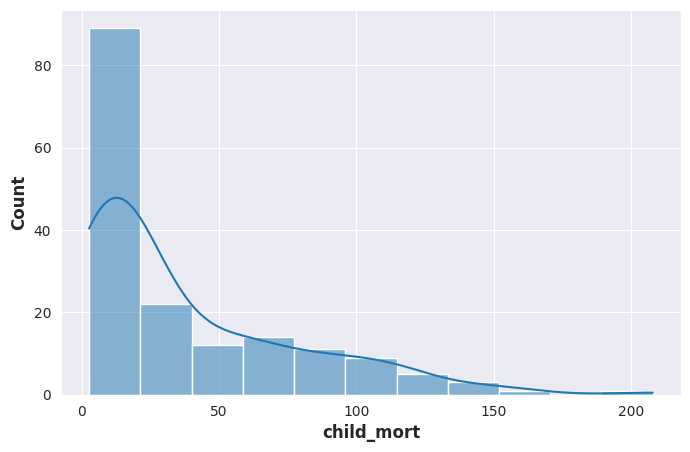

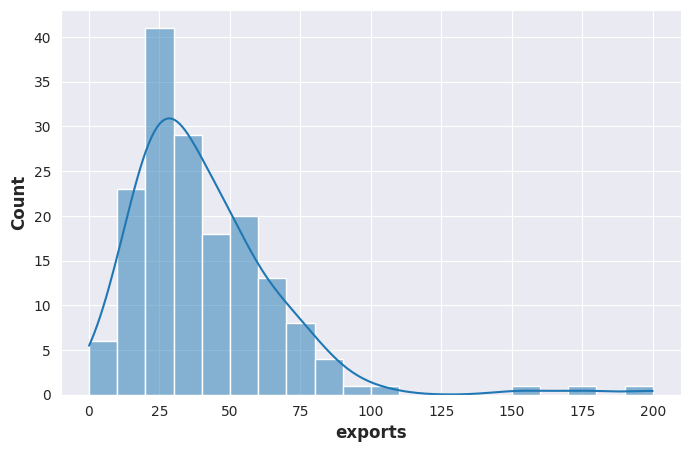

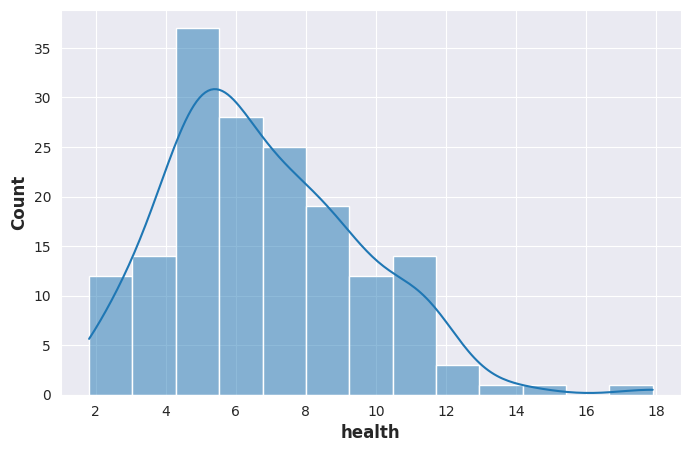

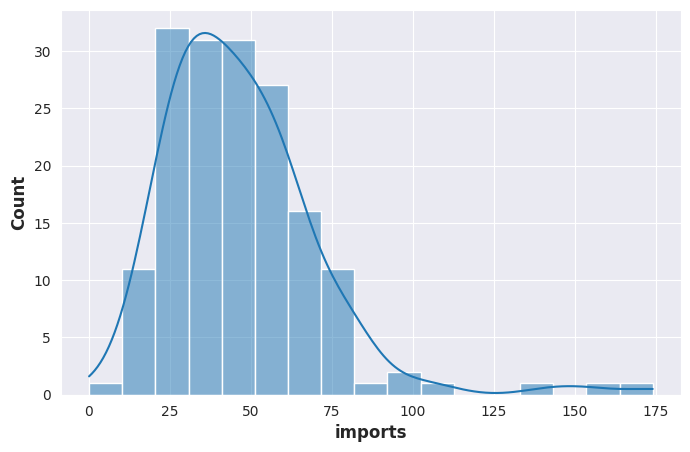

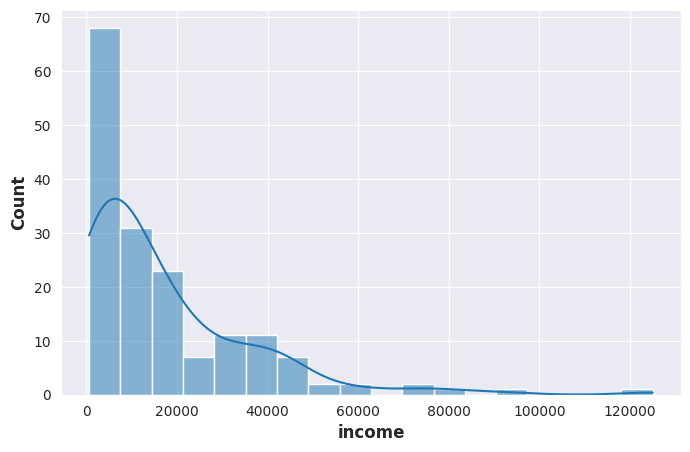

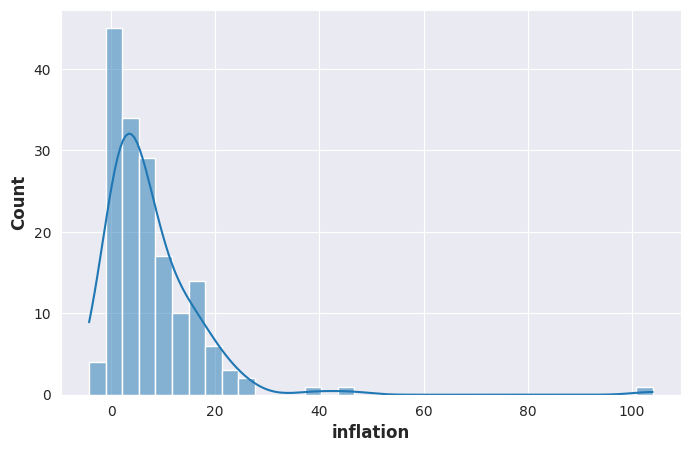

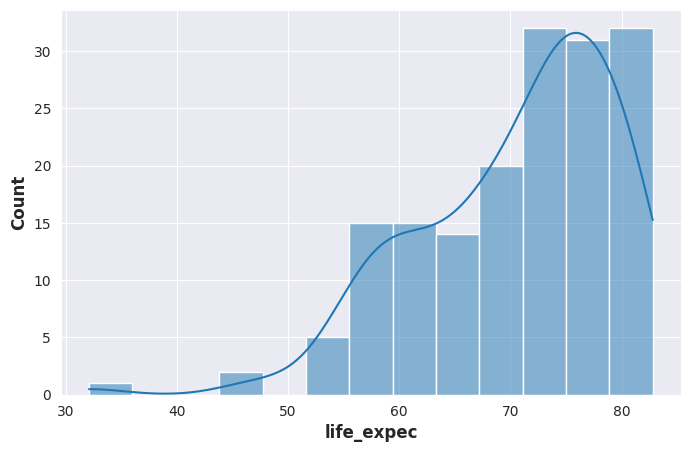

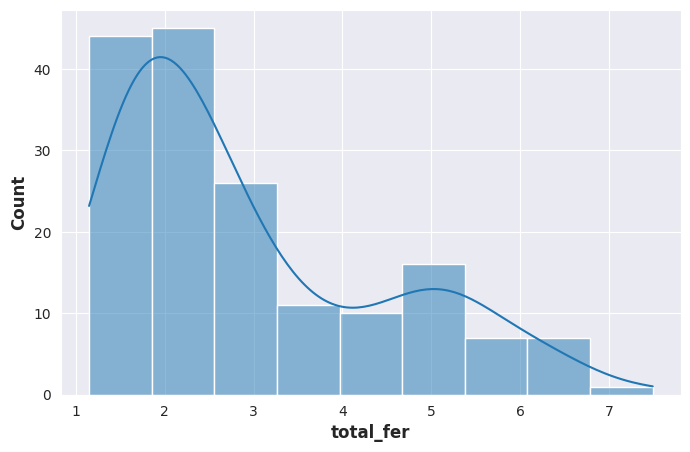

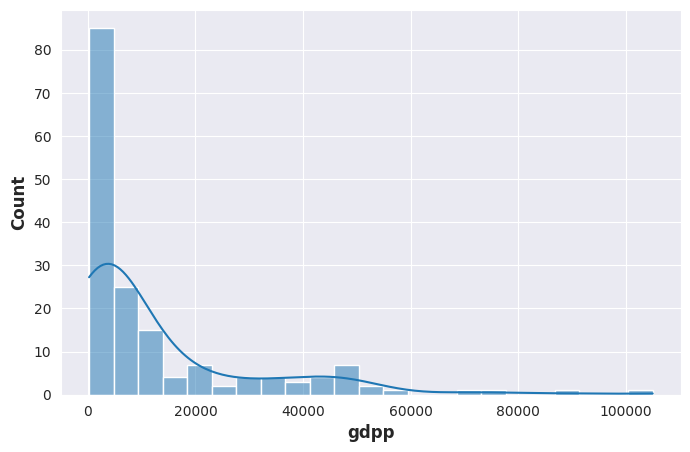

In [ ]:
for col in df.columns:
    fig, axs = plt.subplots(figsize=std_figure_size)
    sns.histplot(data=df, x=col, kde=True, ax=axs)
    plt.show()

==> Distributions require scaling and standardization.

# Clustering

In [ ]:
algos = ["K-means", "Mean shift", "Gaussian mixtures", "Affinity propagation", "DBSCAN", "OPTICS"]

# saving training times for each algo
training_times = []

## Scaling and Standardizing

In [ ]:
X = StandardScaler().fit_transform(df)

In [ ]:
X = PowerTransformer(standardize=False).fit_transform(X)

In [ ]:
X = pd.DataFrame(X, columns=df.columns)

# sanity check
X.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.724216,-1.689968,0.264962,-0.084789,-1.295715,0.142474,-1.152034,1.074441,-1.227840
1,-0.743476,-0.579461,-0.098904,0.069166,-0.476108,-0.380345,0.773045,-1.222757,-0.752019
2,-0.323940,-0.103440,-1.129951,-0.776450,-0.255130,0.526772,0.804200,-0.039130,-0.708663
3,0.921266,0.593847,-1.795773,-0.174621,-0.835070,0.750853,-0.899958,1.150452,-0.819874
4,-1.041113,0.150310,-0.302858,0.430017,0.095168,-0.861306,0.851437,-0.686198,-0.043551


## Dimensionality reduction via UMAP

Prior to clustering, the number of features is reduced from 13 to 2. The main reason behind this is to be able to **directly "see" if the identified clusters make sense**. In addition to this, (i) similarity metrics tend to work better in lower dimensions (distance measures degenerate for large numbers of input features), and (ii) this dimensionality reduction also mitigates the relatively poor "obervations to features ratio" for this dataset.

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, n_jobs=n_parallel_jobs, random_state=fixed_random_state)
embedding = reducer.fit_transform(X)

X = pd.DataFrame(embedding, columns=["comp_1", "comp_2"])

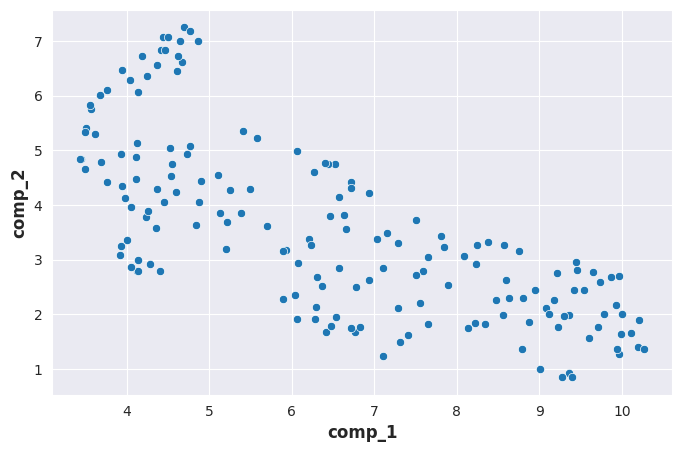

In [ ]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(data= X, x="comp_1", y="comp_2")
plt.show()

## Definition of plotting and convergence check function

In [ ]:
# function to visualize identified clusters

def visualize_clusters(*, df, labels_all, hyperparam_name, hyperparam_val, noise_exist):
    """Visualisation of identified clusters. Only a single hyperparameter is considered.

    Arguments
    =========
    df: pandas.DataFrame
        Dataframe of input features.
    labels_all: list | numpy.array
        Identified cluster IDs.
    hyperparam_name: str | None
        Name of hyperparameter.
    hyperparam_val: float | int | None
        Value of hyperparameter.
    noise_exist: bool
        True if algo models noise, False otherwise.
        Assumes encoding of noise as cluster ID = -1.

    Returns
    =======
    None
    Prints a figure.

    """

    # Checking of input parameters omitted for this notebook

    labels = sorted(pd.Series(labels_all).unique())

    if noise_exist:

        outlier_perc = int(round(( (len(df) - sum(np.where(labels_all == -1, False, True))) / len(df) ) * 100, 0))

        plt.figure(figsize=std_figure_size)
        for label in labels:
            if label == -1:
                marker_style = "*"
            else:
                marker_style = "o"
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label), marker=marker_style)
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}; 'Noise': {outlier_perc}%")
        else:
            plt.title(f"Defaults for all hyperparameters; 'Noise': {outlier_perc}%")
        plt.legend(title="cluster ID")
        plt.show()

    else:

        plt.figure(figsize=std_figure_size)
        for label in labels:
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label))
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}")
        else:
            plt.title(f"Defaults for all hyperparameters")
        plt.legend(title="cluster ID")
        plt.show()


def convergence_check(model):
    """Checking if fitted model converged within the max. number of iterations."""
    if model.n_iter_ < model.max_iter:
        print(f"Algorithm converged successfully!\nn_iter: {model.n_iter_}, max_iter: {model.max_iter}\n")
    else:
        print(f"WARNING: Algorithm did not converge within {model.max_iter} iterations!\n")

## Algo 1: K-means

K-means is the most well-known and "basic" clustering algorithm.
Its most important hyperparamter is ***n_clusters***, which is the number of clusters for the algo to look for.

In [ ]:
# hyperparameter to tune

kmeans_hparam = "n_clusters"

### Identifying the "optimal" number of clusters

In the context of clustering via K-means, the sum of squared distances of points to their respective centroid is known as "**inertia**". Finding an appropriate number of clusters here means finding the point of diminishing returns when increasing the number of centroids. This is done visually via identifying a potential kink in the inertia vs. number of clusters plot.

In [ ]:
inertias_1 = []
range_clusters_1 = np.arange(2, 10, dtype=int)

for n in range_clusters_1:
    kmeans_1 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X)
    inertias_1.append(kmeans_1.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

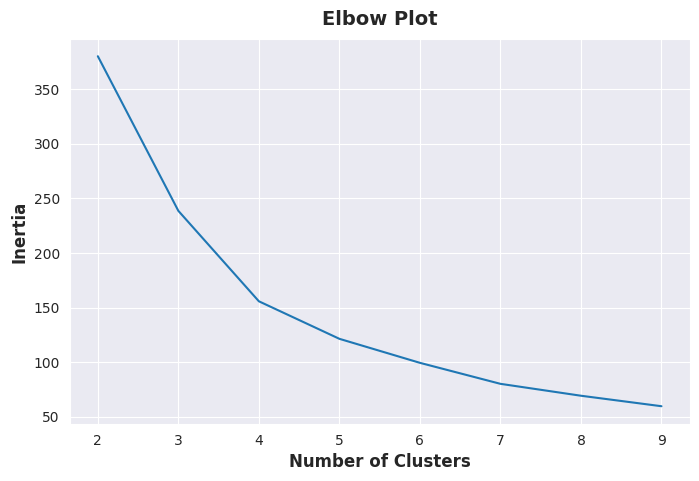

In [ ]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

### Run with optimised *n_clusters*

In [ ]:
%%time

start_time = time.time()

kmeans = KMeans(n_clusters=3, random_state=fixed_random_state)

labels_1 = kmeans.fit_predict(X)

convergence_check(kmeans)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 6, max_iter: 300

CPU times: user 124 ms, sys: 2.96 ms, total: 127 ms
Wall time: 135 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
visualize_clusters(df=X, labels_all=labels_1, hyperparam_name=kmeans_hparam, hyperparam_val=3, noise_exist=False)

In [ ]:
%%time

start_time = time.time()

kmeans = KMeans(n_clusters=4, random_state=fixed_random_state)

labels_1 = kmeans.fit_predict(X)

convergence_check(kmeans)

training_times.append(time.time() - start_time)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Algorithm converged successfully!
n_iter: 4, max_iter: 300

CPU times: user 124 ms, sys: 1.16 ms, total: 125 ms
Wall time: 178 ms


In [ ]:
visualize_clusters(df=X, labels_all=labels_1, hyperparam_name=kmeans_hparam, hyperparam_val=3, noise_exist=False)

## Algo 2: Mean shift

Similar to K-means, Mean shift is a centroid-based algorithm. In contrast to K-means, however, there is **no requirement to specify the number of clusters upfront**. Its main hyperparameter is ***bandwidth***, which represents the extent of the "local search regions". If this parameter is not specified, however, sklearn does provide an estimation for it. Additionally, Mean shift also comes with the option to not necessarily associate all data points with a cluster via setting *cluster_all* to *False*. This aspect of the alogrithm is also explored in the following.

In [ ]:
# hyperparamter to tune

meanshift_hparam = "bandwidth"

### Vanilla run (defaults for all hyperparameters)

In [ ]:
%%time

start_time = time.time()

meanshift = MeanShift(n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_times.append(time.time() - start_time)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Algorithm converged successfully!
n_iter: 19, max_iter: 300

CPU times: user 299 ms, sys: 91.9 ms, total: 391 ms
Wall time: 3.17 s


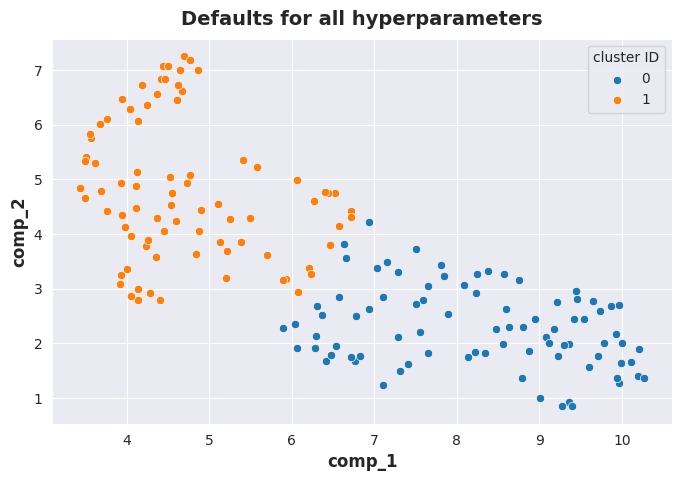

In [ ]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

==> The estimation for *bandwidth* seems to work well here. There is thus no need for any further tuning of this hyperparameter.

### Allowing for 'noise'

This is enabled by setting *cluster_all=False*.

In [ ]:
%%time

start_time = time.time()

meanshift = MeanShift(cluster_all=False, n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_time_meanshift_noise = time.time() - start_time

Algorithm converged successfully!
n_iter: 19, max_iter: 300

CPU times: user 128 ms, sys: 9.12 ms, total: 137 ms
Wall time: 597 ms


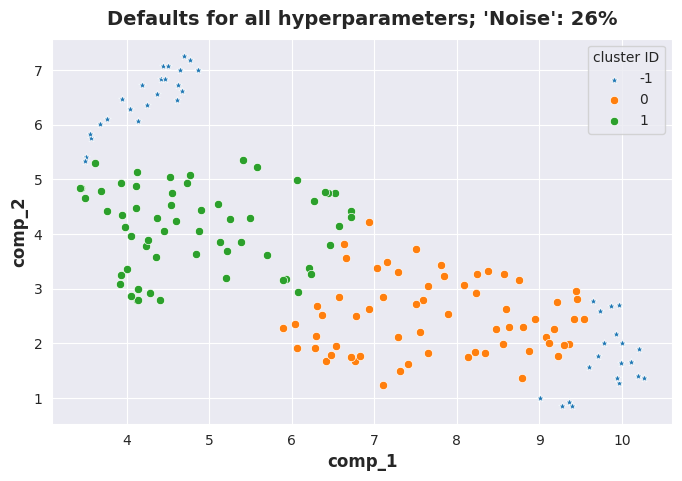

In [ ]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

Data points that the algorithm identifies as "not being part of any cluster" (i.e. 'noise' or 'orphans') are marked as blue stars (cluster ID: -1).

==> Results look sensible but not substantially different to the solution for the default *cluster_all=True* for this dataset.

## Algo 3: Gaussian Mixture

The Gaussian mixture model is, as the name suggests, a distribution-based algorithm. Its main hyperparamter is ***n_components***, which corresponds to the number of clusters to form. As a shortcut here, the number of clusters as identified in the K-means section is adopted.

In [ ]:
# hyperparamter to tune

gmm_hparam = "n_components"

In [ ]:
%%time

start_time = time.time()

gmm = GaussianMixture(n_components=3, random_state=fixed_random_state)

labels_3 = gmm.fit_predict(X)

convergence_check(gmm)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 8, max_iter: 100

CPU times: user 28 ms, sys: 6.95 ms, total: 34.9 ms
Wall time: 27.1 ms


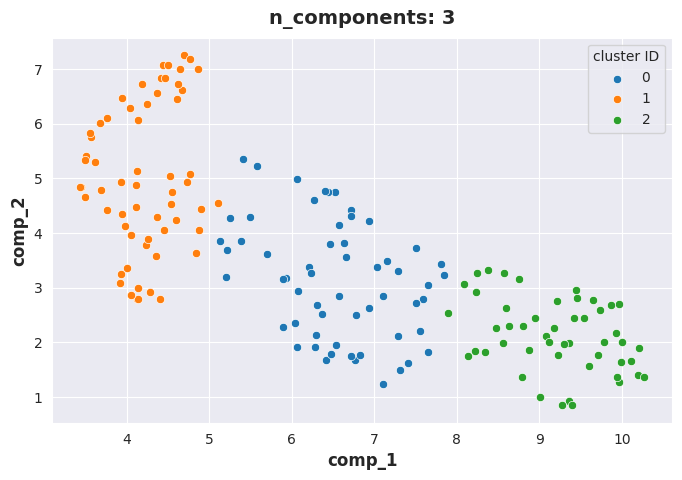

In [ ]:
visualize_clusters(df=X, labels_all=labels_3, hyperparam_name=gmm_hparam, hyperparam_val=3, noise_exist=False)

==> The results look quite reasonable. This is, again, not completely unexpected as the structure of the data does form more of less **elliptic "blobs"** in 2D, which is what the Gaussian mixture model is quite good at capturing.

## Algo 4: Affinity propagation

Affinity propagation does not require specifying the number of clusters upfront. Its main hyperparameter is ***damping***, which is a value in the range of 0.5 (incl.) to 1.0 (excl.).

In [ ]:
# hyperparamter to tune

affprop_hparam = "damping"

### Vanilla run (defaults for all hyperparameters)

In [ ]:
%%time

affprop = AffinityPropagation(random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)

Algorithm converged successfully!
n_iter: 27, max_iter: 200

CPU times: user 15.7 ms, sys: 1.97 ms, total: 17.7 ms
Wall time: 19.3 ms


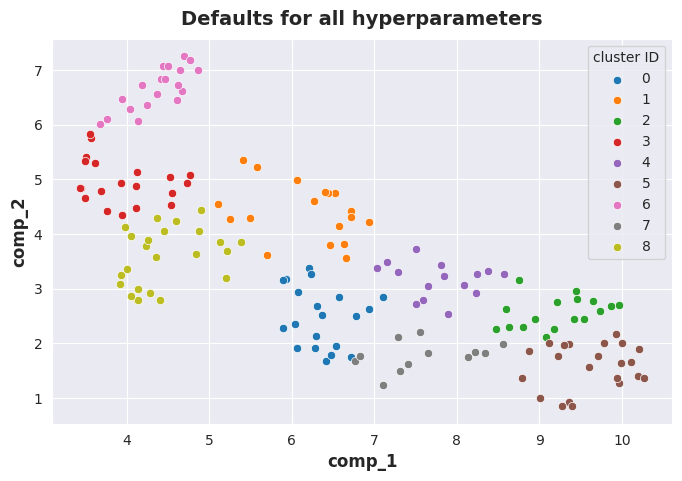

In [ ]:
visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

### Tuning runs for "damping"

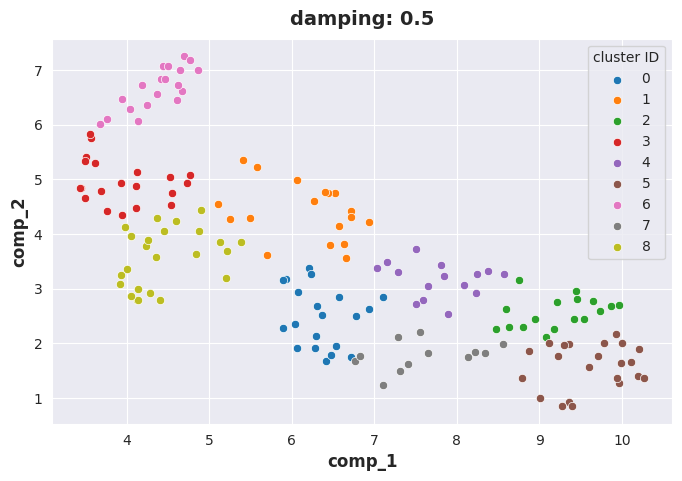

Algorithm converged successfully!
n_iter: 27, max_iter: 500



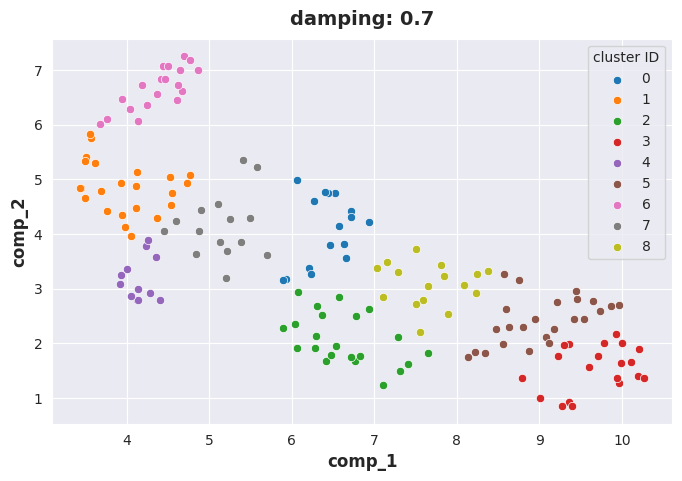

Algorithm converged successfully!
n_iter: 27, max_iter: 500



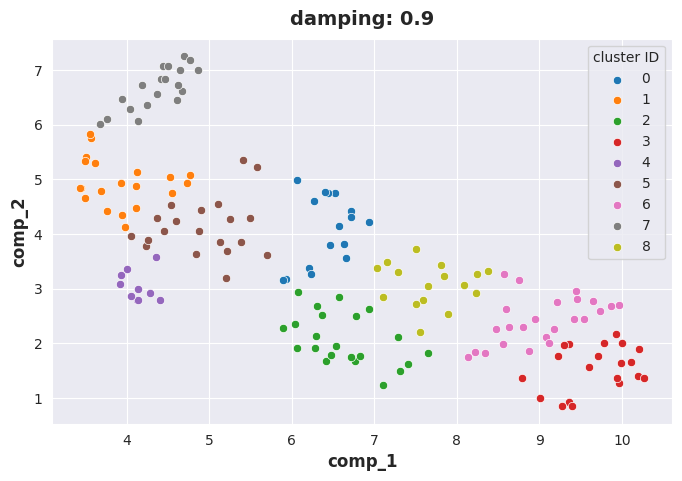

Algorithm converged successfully!
n_iter: 54, max_iter: 500



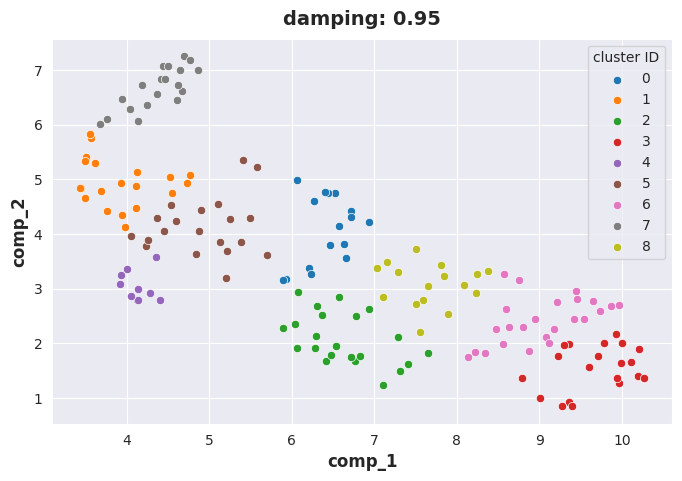

Algorithm converged successfully!
n_iter: 98, max_iter: 500



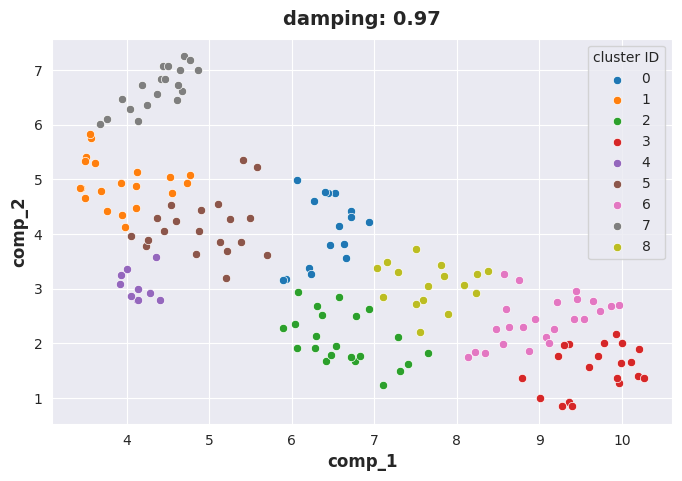

Algorithm converged successfully!
n_iter: 154, max_iter: 500



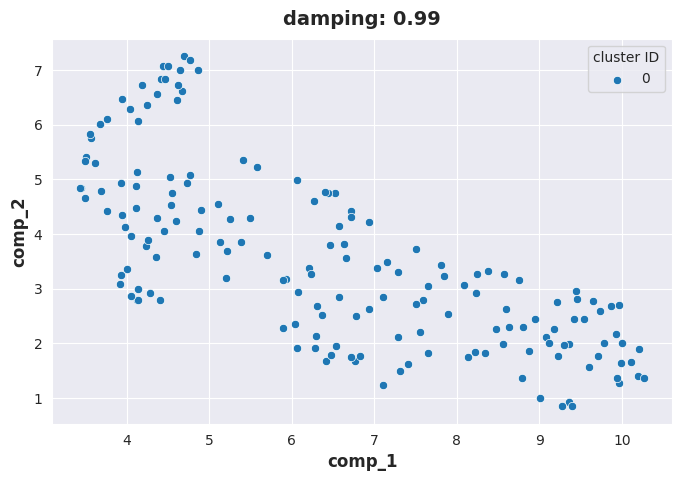

Algorithm converged successfully!
n_iter: 307, max_iter: 500

CPU times: user 4.91 s, sys: 483 ms, total: 5.39 s
Wall time: 5.16 s


In [ ]:
%%time

damps = [0.5, 0.7, 0.9, 0.95, 0.97, 0.99]

for d in damps:
    affprop = AffinityPropagation(damping=d, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=d, noise_exist=False)
    convergence_check(affprop)
74845


==> Tuning "damping" does not seem to be very "effective" for this dataset!

### Tuning runs for "preference"

In order to still get to the "expected solution" of finding 3 clusters, another hyperparamter, ***preference*** is investigated. As stated in the beginning though, the self-imposed contraint here is to only tune a single hyperparameter, leaving all others at their default values, i.e. not looking for any interactions between them.

In [ ]:
# hyperparamter to tune

affprop_hparam = "preference"

In [ ]:
%%time

prefs = [-10, -25, -50, -75, -100]

for p in prefs:
    affprop = AffinityPropagation(preference=p, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=p, noise_exist=False)
    convergence_check(affprop)

==> In contrast to *damping*, *preference* seems to have a much stronger influcence on the number of formed clusters ***for this particular dataset***.

### Re-run with optimised *preference*

In [ ]:
%%time

start_time = time.time()

affprop = AffinityPropagation(preference=-75, max_iter=500, random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)

training_times.append(time.time() - start_time)

## Algo 5: DBSCAN

DBSCAN is a density-based algorithm. It assumes that clusters are of a **roughly similar density**. Its main hyperparameter is ***eps***, which is the maximum distance between two samples for one to be considered as in the neighborhood of the other. Its default value is 0.5. This algorithm comes with a second important hyperparamter, which is ***min_samples***. It represents the number of samples in a neighborhood for a point to be considered as a core point. *Min_samples* is not tuned in the context of this exercise though.

In contrast to algorithms 1 to 4, DBSCAN is **not iterative but deterministic** in nature. Thus no convergence check is required here.

A core feature of DBSCAN is that it also attempts to identify "**noise**", i.e. data points not associated with any cluster. Those data points are represented in the following plots as blue stars with cluster ID -1.

In [ ]:
# hyperparamter to tune

dbscan_hparam = "eps"

### Vanilla run (defaults for all hyperparameters)

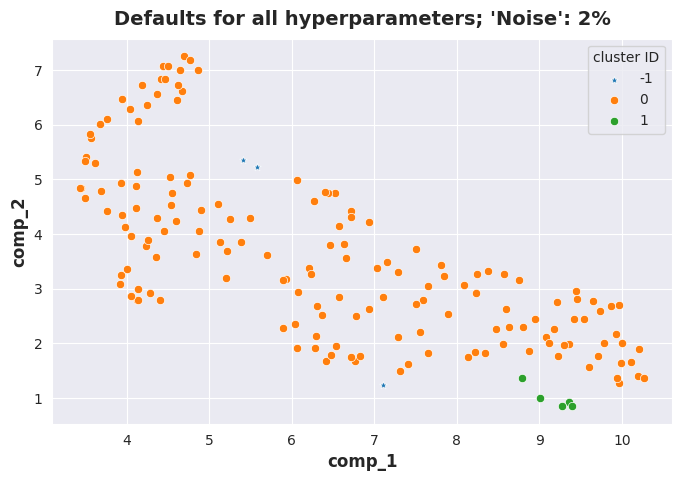

CPU times: user 693 ms, sys: 53.9 ms, total: 747 ms
Wall time: 1.12 s


In [ ]:
%%time

dbscan = DBSCAN(n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

==> The result looks quite convincing! It is important to note here that the structure of data is not at odds with what DBSCAN requires in order to work satisfactorily, i.e. that the **clusters are of a roughly similar density**. Approximately 4% off all datapoints were identified as noise here.

### Tuning runs for *eps*

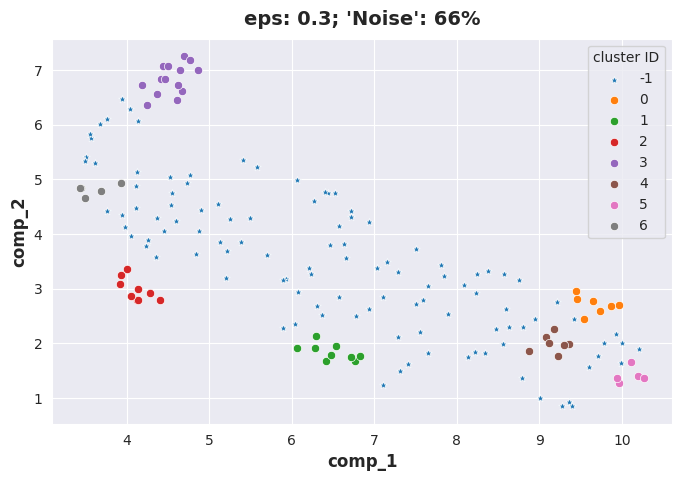

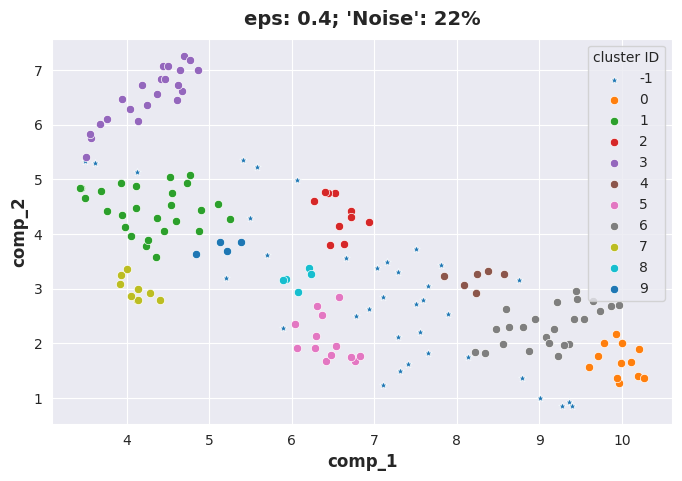

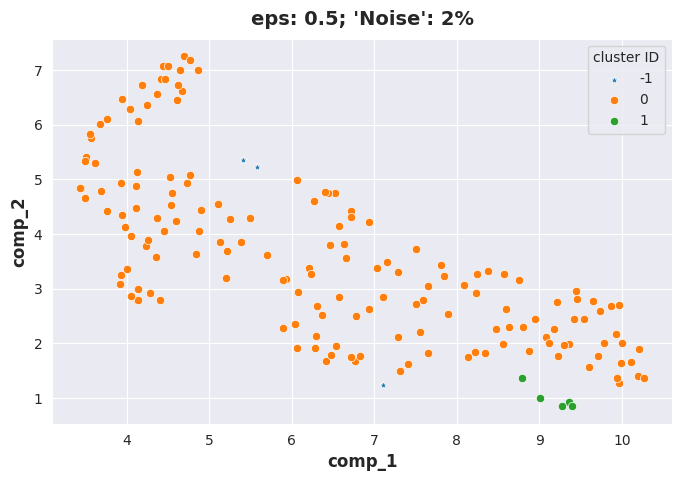

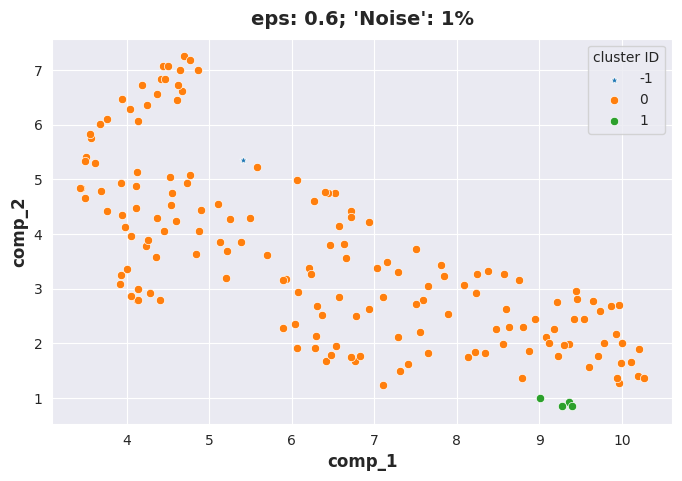

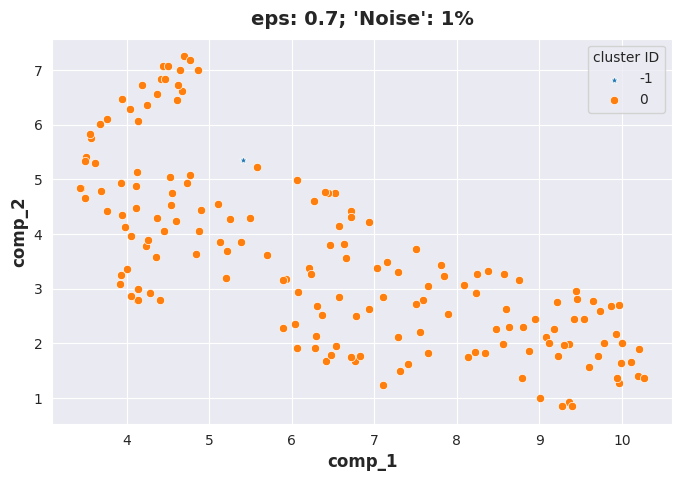

CPU times: user 4.11 s, sys: 257 ms, total: 4.37 s
Wall time: 8.45 s


In [ ]:
%%time

for e in [0.3, 0.4, 0.5, 0.6, 0.7]:

    dbscan = DBSCAN(eps=e, n_jobs=n_parallel_jobs)
    labels_5 = dbscan.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=dbscan_hparam, hyperparam_val=e, noise_exist=True)

==> The algorithm shows quite a high sensitivity to ***eps***. A value of around 0.6 seems to work best for this particular dataset.

### Re-run with optimised *eps*

In [ ]:
%%time

eps_val = 0.6

start_time = time.time()

dbscan = DBSCAN(eps=eps_val, n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 9.22 ms, sys: 910 µs, total: 10.1 ms
Wall time: 29 ms


## Algo 6: OPTICS

OPTICS can be considered an "advanced" version of DBSCAN. Its key difference to the latter is that OPTICS features a **variable neighborhood radius**. Its main hyperparameter to tune is ***min_samples***, which is the number of samples in a neighborhood for a point to be considered as a core point.

In [ ]:
# hyperparamter to tune

optics_hparam = "min_samples"

### Vanilla run (defaults for all hyperparameters)

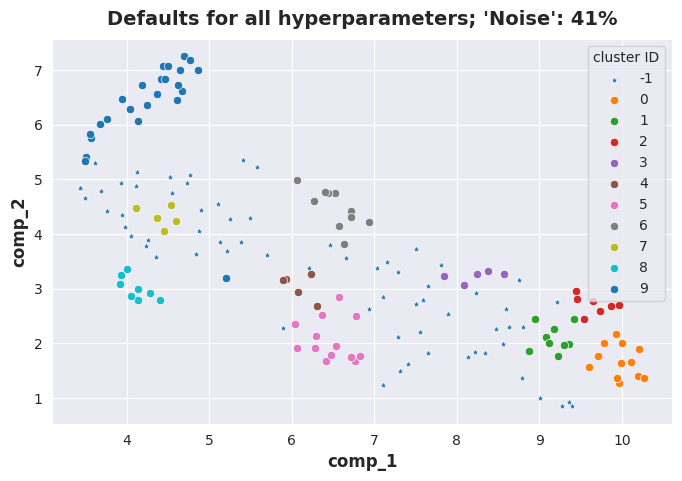

CPU times: user 1.75 s, sys: 208 ms, total: 1.96 s
Wall time: 6 s


In [ ]:
%%time

optics = OPTICS(n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

==> The algorithm identified a considerable number of clusters. Furthermore, a substantial partion of the dataset is labelled as "noise".

### Tuning runs for *min_samples*

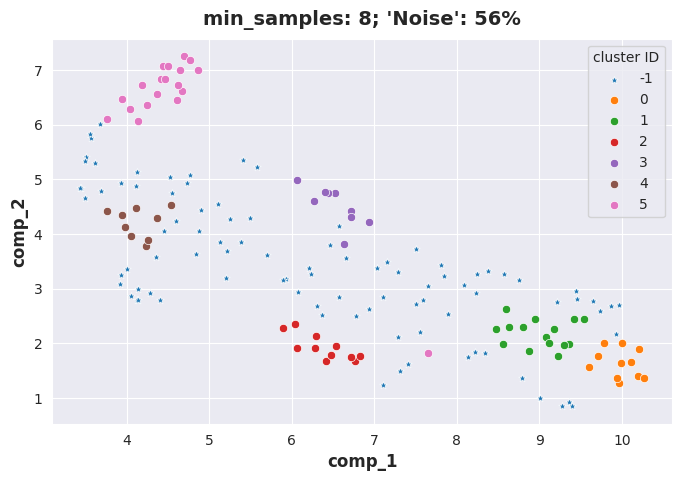

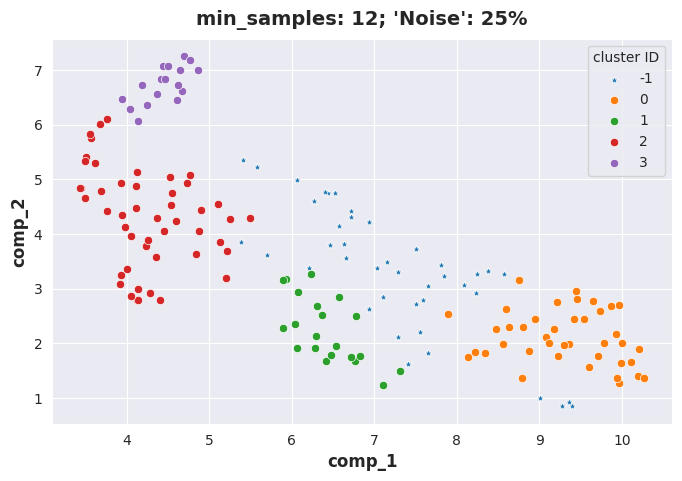

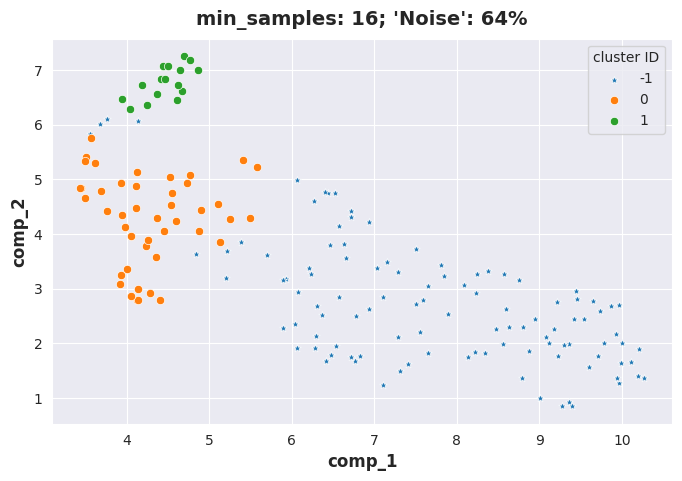

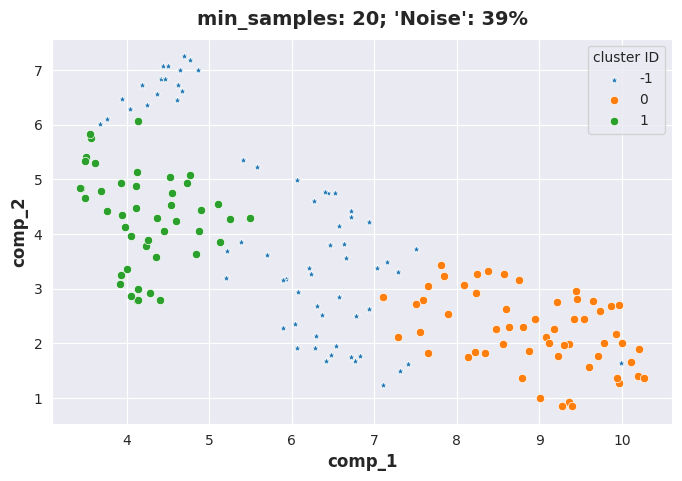

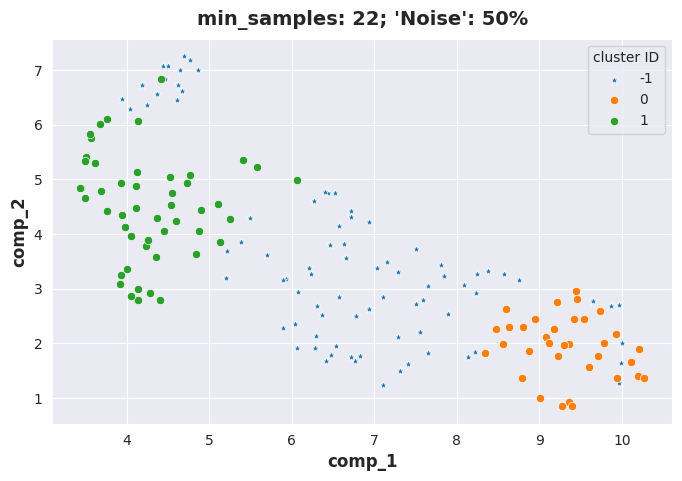

CPU times: user 6.76 s, sys: 1.08 s, total: 7.84 s
Wall time: 29.2 s


In [ ]:
%%time

for n_samples in [8, 12, 16, 20, 22]:

    optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

    labels_6 = optics.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=optics_hparam, hyperparam_val=n_samples, noise_exist=True)

==> An approprate value for *min_samples* would be around 20.

### Re-run with optimised *min_samples*

In [ ]:
%%time

n_samples = 20

start_time = time.time()

optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 431 ms, sys: 162 ms, total: 593 ms
Wall time: 2.18 s


# Comparison of training times

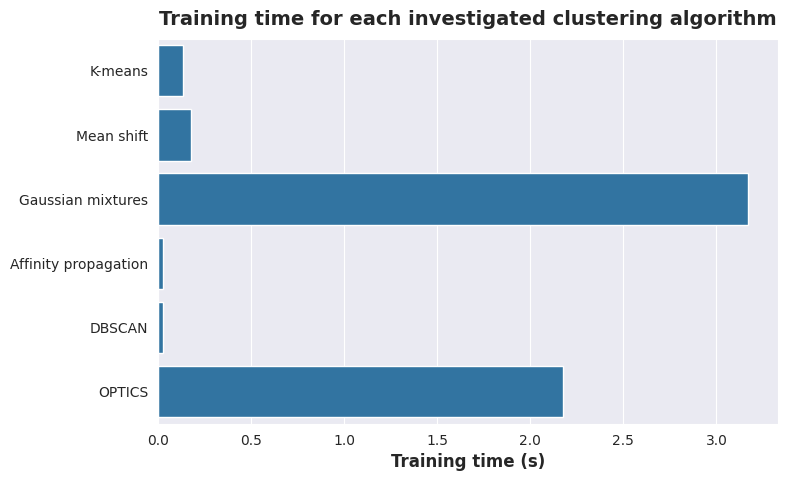

In [ ]:
plt.figure(figsize=std_figure_size)
sns.barplot(y=algos, x=training_times)
plt.title("Training time for each investigated clustering algorithm")
plt.xlabel("Training time (s)")
plt.show()

In [ ]:
# overwriting the training time for Mean shift

training_times[1] = training_time_meanshift_noise

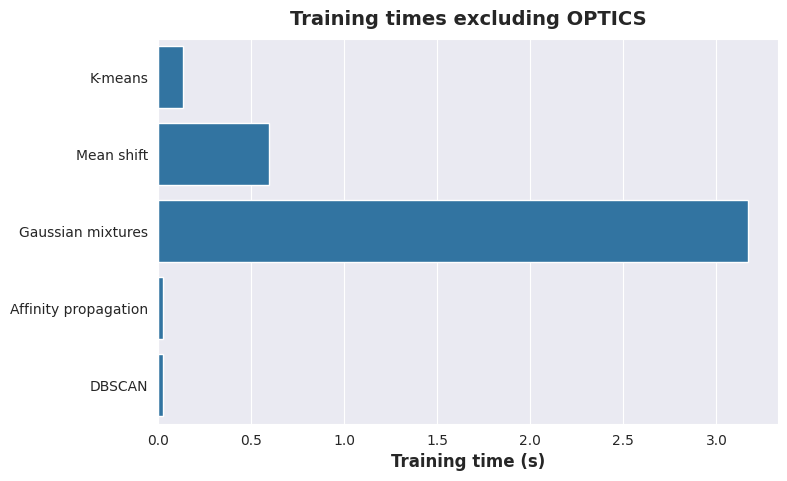

In [ ]:
plt.figure(figsize=std_figure_size)
sns.barplot(y=algos[:-1], x=training_times[:-1])
plt.title("Training times excluding OPTICS")
plt.xlabel("Training time (s)")
plt.show()

# Conclusions